<a href="https://colab.research.google.com/github/kelvinfoo123/Clustering-based-on-user-transaction/blob/main/User_Segmentation_Take_Home_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [2]:
users = pd.read_csv('/content/users.csv')
users.head()

,id,created_at,date_of_birth,gender,country,state,city
0,131d8363-e2a6-4c60-acef-da03e6bfbdc4,2020-03-11 19:38:35,1990-08-16,male,US,CA,San Francisco
1,831216da-744b-48fd-b53f-35515ab96621,2020-05-01 13:09:00,1933-11-22,NaN,US,WA,Tonasket
2,ad7226ed-2d26-45fd-ab37-c3823cd5db0c,2020-03-11 13:45:27,1986-02-02,NaN,US,NY,New York
3,47f21175-1185-4fa3-b928-b2bfabcc42d5,2020-03-11 16:09:06,1990-01-01,male,US,CA,San Francisco
4,1029f5f6-04a3-486f-af2c-716d6b6006e2,2020-03-11 13:47:10,NaN,NaN,US,NaN,NaN


In [3]:
transactions = pd.read_csv('/content/transactions.csv')
transactions.head()

,_id,user_id,account_id,account_name,description,type,amount,date,extra_fields.category.0,extra_fields.category.1,extra_fields.category.2,extra_fields.category_id,extra_fields.merchant_name,extra_fields.name,extra_fields.payment_channel,extra_fields.payment_meta.payment_method,created_at
0,4D2119A1-03D9-48F2-99B7-FEDD80454431,94102846-0B6D-45D8-AFD1-DA80C54F6746,88F8D694-AFF0-4CFC-BBB6-C89D18059472,Chase - Plaid Money Market (4444),ACH Electronic CreditGUSTO PAY 123456,expense,-5850.0,2021-06-08T00:00:00.000Z,Transfer,Debit,NaN,21006000.0,NaN,ACH Electronic CreditGUSTO PAY 123456,other,ACH,2021-06-18T19:14:32.075Z
1,1A6F66DA-2E0F-435D-B10E-E9B5C5A37FE0,94102846-0B6D-45D8-AFD1-DA80C54F6746,88F8D694-AFF0-4CFC-BBB6-C89D18059472,Chase - Plaid Money Market (4444),ACH Electronic CreditGUSTO PAY 123456,expense,-5850.0,2021-05-09T00:00:00.000Z,Transfer,Debit,NaN,21006000.0,NaN,ACH Electronic CreditGUSTO PAY 123456,other,ACH,2021-06-18T19:14:32.075Z
2,99F0E0C2-A3CF-4293-87AC-EA2CD82EE3CB,94102846-0B6D-45D8-AFD1-DA80C54F6746,88F8D694-AFF0-4CFC-BBB6-C89D18059472,Chase - Plaid Money Market (4444),ACH Electronic CreditGUSTO PAY 123456,expense,-5850.0,2021-04-09T00:00:00.000Z,Transfer,Debit,NaN,21006000.0,NaN,ACH Electronic CreditGUSTO PAY 123456,other,ACH,2021-06-18T19:14:32.075Z
3,28D4C5D0-2DF1-4B9F-8895-109CE77DFAFA,94102846-0B6D-45D8-AFD1-DA80C54F6746,88F8D694-AFF0-4CFC-BBB6-C89D18059472,Chase - Plaid Money Market (4444),ACH Electronic CreditGUSTO PAY 123456,expense,-5850.0,2021-03-10T00:00:00.000Z,Transfer,Debit,NaN,21006000.0,NaN,ACH Electronic CreditGUSTO PAY 123456,other,ACH,2021-06-18T19:14:32.075Z
4,77223F04-ACBF-49C8-B101-DAD9B5F2E1A7,94102846-0B6D-45D8-AFD1-DA80C54F6746,88F8D694-AFF0-4CFC-BBB6-C89D18059472,Chase - Plaid Money Market (4444),ACH Electronic CreditGUSTO PAY 123456,expense,-5850.0,2021-02-08T00:00:00.000Z,Transfer,Debit,NaN,21006000.0,NaN,ACH Electronic CreditGUSTO PAY 123456,other,ACH,2021-06-18T19:14:32.075Z


### **Part 1: Exploratory Data Analysis**

**Q1a. How many user IDs are there?**

In [4]:
print(f"There are {len(users)} user IDs.")

# Are all user IDs distinct?
users.groupby('id')['id'].count().sort_values(ascending = False).head()

There are 803 user IDs.


,id
id,
ffea340e-e0b8-4a18-8fee-b418e188f010,1
000bac87-d019-4d24-8d46-ff0a74de4bdc,1
00a54873-bdba-49e8-aee6-1cba8eb67f2e,1
f9fe59f2-3216-49c2-8cfb-f15db891985f,1
f9e4933b-6fdb-4471-9f96-edf195d8d484,1


Since the largest count for each user ID is 1, there are no duplicate user IDs. There are 803 distinct user IDs.

**Q1b. Create a profile for the users based on gender, age, creation date and location.**
- 94% of the user records had no gender values. For the remaining 6% of the user records with gender values, 77% of the users were Male and 17% were Female.
- All 803 users were from United States.
- 22% of the users had no state recorded. Among the remaining 78% of the user records with state values, 40% were from California, 14% were from Maryland and 10% were from North Carolina.
- 22% of the user records had no age value since they did not have a recorded date of birth. Among the remaining 78% of the user record, 59% of the users were aged 31-40, 22% of the users were aged 41-60 and 18% of the users were aged 30 and below. Less than 1% of the users were aged above 60.
- All 803 users either created their account 4 or 5 years ago.

In [5]:
# Profile based on gender
print(f"Number of null values for gender: {users['gender'].isna().sum()} ({round(users['gender'].isna().sum() / len(users), 2) * 100}%)")
users.groupby('gender').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x / x.sum(), 2)}).unstack().reset_index()

Number of null values for gender: 751 (94.0%)


/tmp/ipython-input-663090542.py:3: FutureWarning: using <function <lambda> at 0x7ccaf92add00> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  users.groupby('gender').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x / x.sum(), 2)}).unstack().reset_index()


gender,index,female,male,non-binary,unanswered
0,count,9.00,40.00,2.00,1.00
1,proportion,17.31,76.92,3.85,1.92


In [6]:
# Profile based on country
print(f"Number of null values for country: {users['country'].isna().sum()} ({users['country'].isna().sum() / len(users)}%)")
users.groupby('country').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x/x.sum(),2)}).unstack().reset_index()

Number of null values for country: 0 (0.0%)


/tmp/ipython-input-3737168668.py:3: FutureWarning: using <function <lambda> at 0x7ccaf92ad120> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  users.groupby('country').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x/x.sum(),2)}).unstack().reset_index()


country,index,US
0,count,803.0
1,proportion,100.0


In [7]:
# Profile based on state
print(f"Number of null values for state: {users['state'].isna().sum()} ({100.0 * round(users['state'].isna().sum() / len(users),2)}%)")
users.groupby('state').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x/x.sum(),2)}).unstack(level = 0).sort_values(by = 'count', ascending = False).head()

Number of null values for state: 174 (22.0%)


/tmp/ipython-input-959145631.py:3: FutureWarning: using <function <lambda> at 0x7ccaf92af600> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  users.groupby('state').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x/x.sum(),2)}).unstack(level = 0).sort_values(by = 'count', ascending = False).head()


,count,proportion
state,,
CA,252.0,40.06
MD,89.0,14.15
NC,63.0,10.02
NY,61.0,9.70
MA,31.0,4.93


Assumption: For profiling based on creation date and date of birth, we assume current year to be 2025. Hence, age = 2025 - date of birth.

Percentage of null values for age: 21.67%


<Axes: xlabel='age', ylabel='Count'>

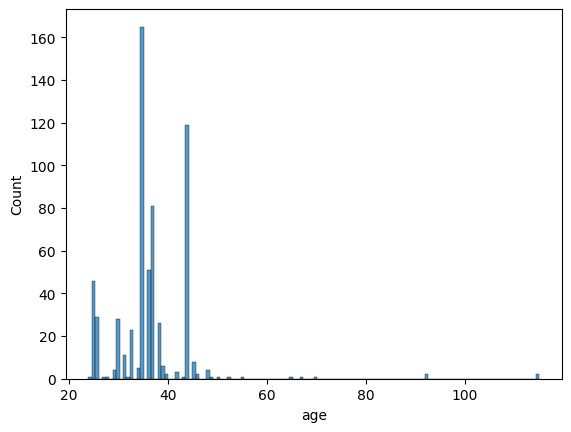

In [8]:
# Histogram based on age
users['year'] = pd.to_datetime(users['date_of_birth'], errors = 'coerce', format = 'mixed').dt.year
users['age'] = 2025 - users['year']
print(f"Percentage of null values for age: {round(100.0 * users['age'].isna().sum() / len(users),2)}%")
sns.histplot(data = users, x = 'age')

In [9]:
# Binning of age
bins = [0, 30, 40, 60, 100]
labels = ['0-30', '31-40', '41-60', 'Above 60']
users['age_bin'] = pd.cut(users['age'], bins = bins, labels = labels)

users.groupby('age_bin').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x / x.sum(),2)}).unstack().reset_index()

/tmp/ipython-input-2627148217.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  users.groupby('age_bin').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x / x.sum(),2)}).unstack().reset_index()
/tmp/ipython-input-2627148217.py:6: FutureWarning: using <function <lambda> at 0x7ccaf8c33a60> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  users.groupby('age_bin').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x / x.sum(),2)}).unstack().reset_index()


age_bin,index,0-30,31-40,41-60,Above 60
0,count,110.00,371.00,141.00,5.0
1,proportion,17.54,59.17,22.49,0.8


Percentage of null values for time from creation: 0.0%


<Axes: xlabel='time_from_creation', ylabel='Count'>

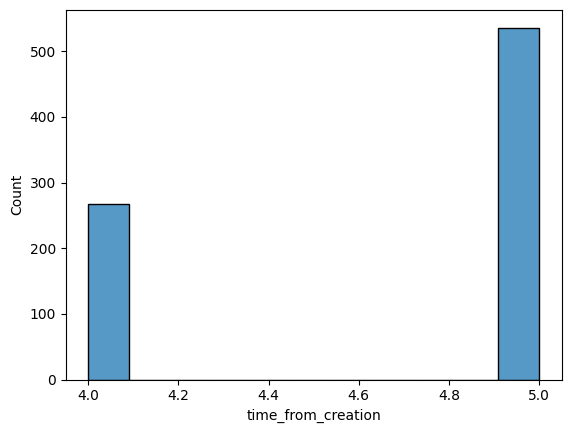

In [10]:
# Histogram based on time from creation date
users['creation_year'] = pd.to_datetime(users['created_at'], errors = 'coerce', format = 'mixed').dt.year
users['time_from_creation'] = 2025 - users['creation_year']
print(f"Percentage of null values for time from creation: {round(100.0 * users['created_at'].isna().sum() / len(users),2)}%")
sns.histplot(data = users, x = 'time_from_creation')

**Q2a. How many distinct transactions are there?**

In [11]:
print(f"There are {len(transactions)} transactions.")

# Are there duplicate transaction IDs?
transactions.groupby('_id')['_id'].count().sort_values(ascending = False).head(5)

There are 11059 transactions.


,_id
_id,
FFF8027D-51A1-4896-BFAA-C6BA62626393,1
0002AA4C-8ED1-4E06-877C-73C3E45CA8ED,1
000B3B82-9705-487D-A8C8-06DA765A5E9F,1
FF952570-9EC2-454A-A884-864D32B33836,1
FF950130-C666-46DF-A241-0494C3312552,1


Since the largest count for each transaction ID is 1, there are no duplicate transaction IDs. There are 11,059 unique transaction IDs.

**Q2b. How many users had more than one account?**

In [12]:
transactions.isna().sum()

,0
_id,0
user_id,0
account_id,0
account_name,0
description,2742
type,0
amount,0
date,0
extra_fields.category.0,2742
extra_fields.category.1,3185


In [13]:
num_accounts_per_user = transactions.groupby('user_id')['account_id'].nunique().reset_index().rename(columns = {'account_id': 'Number of accounts'})
print(f"There are {len(num_accounts_per_user[num_accounts_per_user['Number of accounts'] >= 2])} users with more than 1 account. The maximum number of accounts held by a user is {max(num_accounts_per_user['Number of accounts'])}")

There are 14 users with more than 1 account. The maximum number of accounts held by a user is 7


**Q2c. What are the most popular transaction types?**

In [14]:
transactions.groupby('type').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x/x.sum(),2)}).unstack().reset_index()

/tmp/ipython-input-2236421934.py:1: FutureWarning: using <function <lambda> at 0x7ccaf962e7a0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  transactions.groupby('type').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x/x.sum(),2)}).unstack().reset_index()


type,index,expense,income,transfer
0,count,7239.00,3197.00,623.00
1,proportion,65.46,28.91,5.63


65% of the transactions were for expenses, 29% were for income and 6% of the transactions were transfers.

**Q2d. Analyse the distribution of the transaction amount. Conduct a statistical test to determine if the distribution of the transaction amount differs significantly across different transaction type.**

<Axes: xlabel='amount', ylabel='Count'>

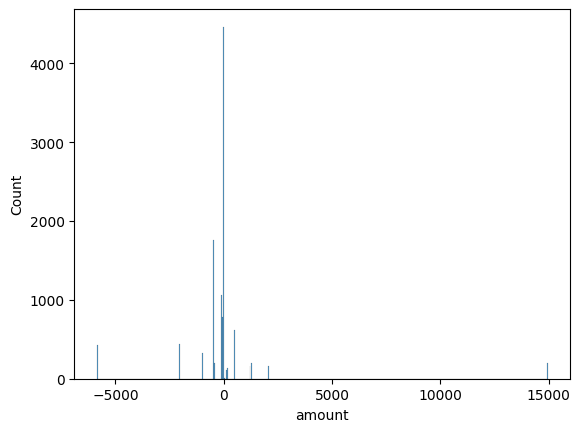

In [15]:
sns.histplot(data = transactions, x = 'amount')

<Axes: xlabel='amount', ylabel='Count'>

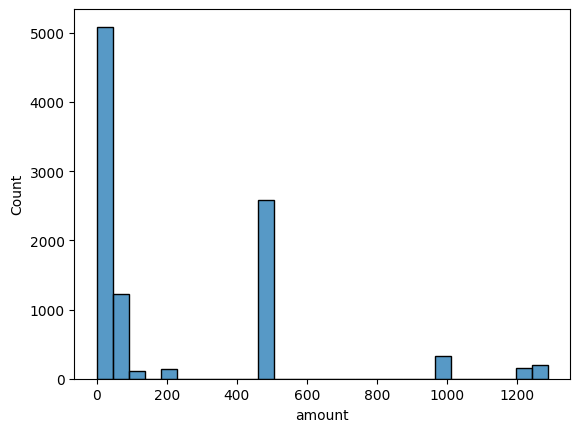

In [16]:
# Take absolute value for negative transaction amount
transactions['amount'] = abs(transactions['amount'])

# Distribution for transaction amount < 2000
transactions_less_than_2000 = transactions[transactions['amount'] < 2000]
sns.histplot(data = transactions_less_than_2000, x = 'amount')

In [17]:
bins = [0, 200, 400, 1000, 2000, 20000]
labels = ['200 and below', '201 to 400', '401 to 1000', '1001 to 2000', 'Above 2000']
transactions['amount bins'] = pd.cut(transactions['amount'], bins = bins, labels = labels)

transactions.groupby('amount bins').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x / x.sum(), 2)}).unstack().reset_index()

/tmp/ipython-input-2623187395.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  transactions.groupby('amount bins').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x / x.sum(), 2)}).unstack().reset_index()
/tmp/ipython-input-2623187395.py:5: FutureWarning: using <function <lambda> at 0x7ccaf86c3600> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  transactions.groupby('amount bins').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x / x.sum(), 2)}).unstack().reset_index()


amount bins,index,200 and below,201 to 400,401 to 1000,1001 to 2000,Above 2000
0,count,6421.00,136.00,2906.00,364.00,1232.00
1,proportion,58.06,1.23,26.28,3.29,11.14


Majority of the transactions had transaction amount of 1000 and below. 58% of the transactions had transaction amount of 200 and below. 26% of them had transaction amount of between 201 and 400 inclusive.

In [18]:
transactions.groupby('type')['amount'].sum().to_frame('amount').assign(proportion = lambda x: round(100.0 * x['amount'] / x['amount'].sum(), 2)).reset_index()

,type,amount,proportion
0,expense,4823485.38,53.56
1,income,4167442.49,46.27
2,transfer,15575.00,0.17


<Axes: xlabel='type', ylabel='amount'>

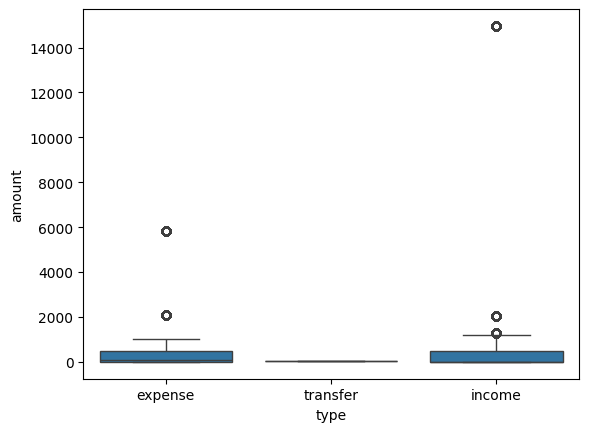

In [19]:
sns.boxplot(data = transactions, x = 'type', y = 'amount')

In [20]:
stats.kruskal(transactions[transactions['type'] == 'expense']['amount'], transactions[transactions['type'] == 'income']['amount'], transactions[transactions['type'] == 'transfer']['amount'])

KruskalResult(statistic=np.float64(164.85432214480238), pvalue=np.float64(1.5934512723264507e-36))

As transaction amounts were not normally distributed, kruskal-wallis test was used instead of anova to test for the difference in distribution of amount between different transaction type.

$H_0$: There is no difference in the median transaction amount between the three transaction type. \
$H_1$: At least one of the transaction type had a different median in transaction amount from the other transaction types.

Since p-value < 0.05, we reject $H_0$ and conclude that at least one of the transaction type had a different median in transaction amount from the other transaction types.

**Q2d. Conduct an analysis on users' source of spending and income.**
- 25% of the transactions were expenses towards food and drink in restaurants. 63% of these transactions were in fast food chains while the remaining 37% were in coffee shops.
- 4% of the transactions were expenses for recreational purposes spent in gyms and fitness centres. Another 4% of the transaction were expenses in sports shops.
- 7% of the transactions were transfer expenses. 57% of these involves debit transfers while the remaining involves deposit.
- 15% were expenses for travel. 74% of these were for taxi services while the remaining were for airline and aviation services.
- 5% of the transactions were income from credit transfer and 6% of the transactions were income from airline and aviation services.
- 6% of the transactions were for credit card payment.

In terms of number of transactions, majority of the transactions were expenses towards food and drink in restaurants, in particular fast food chains. Travel expenses also covered 15% of the transactions, in particular towards taxi services.

- 56% of the total transaction amount were transfer expenses. 57% of these involves debit transfer and the remaining involves deposit.
- Only 10% of the total transaction amount were expenses towards food and drink in restaurants. 99% of the transaction amount were expenses in fast food chains while the remaining 1% were in coffee shops.
- 6% of the total transaction amount were income from airline and aviation services.
-  4% of the total transaction amount were expenses towards travel. 74% of these were for taxi services and the remaining were for airline and aviation services.

In terms of amount transacted, majority were for transfer purposes, in particular debit transfer. Only a small percentage of the total transaction amount were expenses towards food and drink (10%) and travel (4%).

In [21]:
transactions['extra_fields.category.0'].unique()

array(['Transfer', 'Payment', 'Travel', 'Food and Drink', 'Shops',
       'Recreation', nan], dtype=object)

In [22]:
print(f"Number of null values for extra field category 0: {transactions['extra_fields.category.0'].isna().sum()} ({round(transactions['extra_fields.category.0'].isna().sum() / len(transactions), 2) * 100}%)")
transactions.groupby(['type', 'extra_fields.category.0']).size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x/len(transactions),2)}).unstack().reset_index()

Number of null values for extra field category 0: 2742 (25.0%)


/tmp/ipython-input-4200724457.py:2: FutureWarning: using <function <lambda> at 0x7ccaf8598f40> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  transactions.groupby(['type', 'extra_fields.category.0']).size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x/len(transactions),2)}).unstack().reset_index()
/tmp/ipython-input-4200724457.py:2: FutureWarning: using <function <lambda> at 0x7ccaf8599800> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  transactions.groupby(['type', 'extra_fields.category.0']).size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x/len(transactions),2)}).unstack().reset_index()


extra_fields.category.0,level_0,type,Food and Drink,Payment,Recreation,Shops,Transfer,Travel
0,count,expense,2724.00,443.00,443.00,443.00,749.00,1669.00
1,count,income,NaN,NaN,NaN,NaN,607.00,616.00
2,count,transfer,NaN,623.00,NaN,NaN,NaN,NaN
3,proportion,expense,24.63,4.01,4.01,4.01,6.77,15.09
4,proportion,income,NaN,NaN,NaN,NaN,5.49,5.57
5,proportion,transfer,NaN,5.63,NaN,NaN,NaN,NaN


<Axes: xlabel='count', ylabel='extra_fields.category.0'>

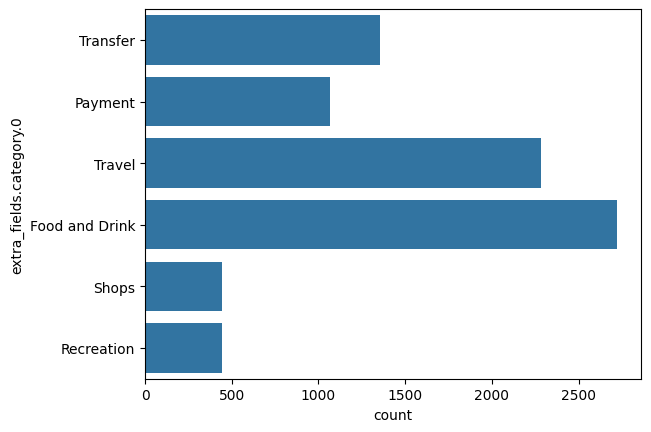

In [23]:
sns.countplot(data = transactions, y = 'extra_fields.category.0')

In [24]:
transactions.groupby(['type', 'extra_fields.category.0'])['amount'].sum().to_frame().assign(proportion = lambda x: round(100.0 * x['amount'] / x['amount'].sum(), 2)).reset_index()

,type,extra_fields.category.0,amount,proportion
0,expense,Food and Drink,505918.22,10.03
1,expense,Payment,920775.50,18.25
2,expense,Recreation,34775.50,0.69
3,expense,Shops,221500.00,4.39
4,expense,Transfer,2810250.00,55.69
5,expense,Travel,226709.30,4.49
6,income,Transfer,2561.54,0.05
7,income,Travel,308000.00,6.10
8,transfer,Payment,15575.00,0.31


<Axes: xlabel='extra_fields.category.0', ylabel='amount'>

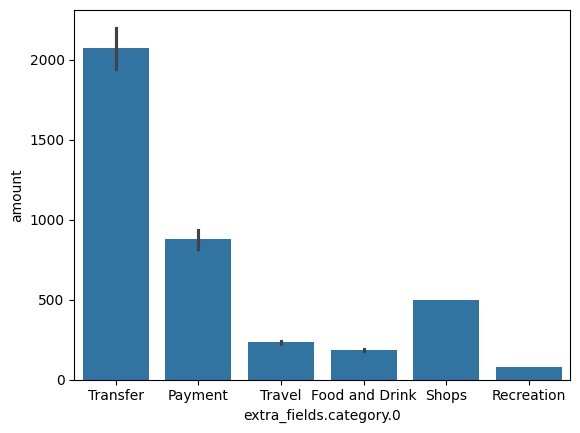

In [25]:
sns.barplot(data = transactions, x = 'extra_fields.category.0', y = 'amount')

In [26]:
category1_count = transactions.groupby(['type', 'extra_fields.category.0', 'extra_fields.category.1']).size().reset_index(name = 'count')
category1_count['proportion'] = round((category1_count['count'] / category1_count.groupby(['type', 'extra_fields.category.0'])['count'].transform('sum') * 100),2)
category1_count

,type,extra_fields.category.0,extra_fields.category.1,count,proportion
0,expense,Food and Drink,Restaurants,2724,100.00
1,expense,Recreation,Gyms and Fitness Centers,443,100.00
2,expense,Shops,Sporting Goods,443,100.00
3,expense,Transfer,Debit,425,56.74
4,expense,Transfer,Deposit,324,43.26
5,expense,Travel,Airlines and Aviation Services,439,26.30
6,expense,Travel,Taxi,1230,73.70
7,income,Transfer,Credit,607,100.00
8,income,Travel,Airlines and Aviation Services,616,100.00
9,transfer,Payment,Credit Card,623,100.00


In [27]:
transactions.groupby(['type', 'extra_fields.category.0', 'extra_fields.category.1'])['amount'].sum().to_frame().assign(proportion = lambda x: round(100.0 * x['amount'] / x.groupby(['type', 'extra_fields.category.0'])['amount'].transform(sum), 2)).reset_index()

/tmp/ipython-input-3694956263.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  transactions.groupby(['type', 'extra_fields.category.0', 'extra_fields.category.1'])['amount'].sum().to_frame().assign(proportion = lambda x: round(100.0 * x['amount'] / x.groupby(['type', 'extra_fields.category.0'])['amount'].transform(sum), 2)).reset_index()


,type,extra_fields.category.0,extra_fields.category.1,amount,proportion
0,expense,Food and Drink,Restaurants,505918.22,100.00
1,expense,Recreation,Gyms and Fitness Centers,34775.50,100.00
2,expense,Shops,Sporting Goods,221500.00,100.00
3,expense,Transfer,Debit,2486250.00,88.47
4,expense,Transfer,Deposit,324000.00,11.53
5,expense,Travel,Airlines and Aviation Services,219500.00,96.82
6,expense,Travel,Taxi,7209.30,3.18
7,income,Transfer,Credit,2561.54,100.00
8,income,Travel,Airlines and Aviation Services,308000.00,100.00
9,transfer,Payment,Credit Card,15575.00,100.00


In [28]:
category2_count = transactions.groupby(['extra_fields.category.1', 'extra_fields.category.2']).size().reset_index(name = 'count')
category2_count['proportion'] = round((category2_count['count'] / category2_count.groupby('extra_fields.category.1')['count'].transform('sum') * 100), 2)
category2_count

,extra_fields.category.1,extra_fields.category.2,count,proportion
0,Restaurants,Coffee Shop,614,36.74
1,Restaurants,Fast Food,1057,63.26


In [29]:
transactions.groupby(['extra_fields.category.1', 'extra_fields.category.2'])['amount'].sum().to_frame().assign(proportion = lambda x: round(100.0 * x['amount'] / x.groupby(['extra_fields.category.1'])['amount'].transform(sum), 2)).reset_index()

/tmp/ipython-input-519286570.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  transactions.groupby(['extra_fields.category.1', 'extra_fields.category.2'])['amount'].sum().to_frame().assign(proportion = lambda x: round(100.0 * x['amount'] / x.groupby(['extra_fields.category.1'])['amount'].transform(sum), 2)).reset_index()


,extra_fields.category.1,extra_fields.category.2,amount,proportion
0,Restaurants,Coffee Shop,2658.62,1.15
1,Restaurants,Fast Food,228868.00,98.85


**Q2e. Conduct an analysis on transaction over time.**
- 50% of the transactions occurred in 2021 and 32% of the transactions occured in 2020.
- While the other months account for 4-6% of the transactions each, June accounted for 42% of the transactions. In particular, June 2021 accounted for 38% of the transactions.

In [30]:
transactions['year'] = pd.to_datetime(transactions['date'], errors = 'coerce', format = 'mixed').dt.year
transactions['month'] = pd.to_datetime(transactions['date'], errors = 'coerce', format = 'mixed').dt.month

transactions.groupby('year').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x/x.sum(), 2)}).unstack().reset_index()

/tmp/ipython-input-2576909892.py:4: FutureWarning: using <function <lambda> at 0x7ccaf84844a0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  transactions.groupby('year').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x/x.sum(), 2)}).unstack().reset_index()


year,index,2019,2020,2021
0,count,1985.00,3510.00,5564.00
1,proportion,17.95,31.74,50.31


In [31]:
transactions.groupby('month').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x/x.sum(), 2)}).unstack().reset_index()

/tmp/ipython-input-759216139.py:1: FutureWarning: using <function <lambda> at 0x7ccaf865f880> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  transactions.groupby('month').size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x/x.sum(), 2)}).unstack().reset_index()


month,index,1,2,3,4,5,6,7,8,9,10,11,12
0,count,583.00,548.00,574.00,561.00,561.00,4694.00,597.0,597.0,581.00,607.00,581.00,575.0
1,proportion,5.27,4.96,5.19,5.07,5.07,42.45,5.4,5.4,5.25,5.49,5.25,5.2


In [32]:
transactions.groupby(['year', 'month']).size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x/x.sum(), 2)}).unstack().reset_index()

/tmp/ipython-input-3186666405.py:1: FutureWarning: using <function <lambda> at 0x7ccaf8484fe0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  transactions.groupby(['year', 'month']).size().agg({'count': lambda x:x, 'proportion': lambda x: round(100.0 * x/x.sum(), 2)}).unstack().reset_index()


month,level_0,year,1,2,3,4,5,6,7,8,9,10,11,12
0,count,2019,NaN,NaN,NaN,NaN,NaN,168.00,301.00,301.00,296.00,322.00,296.00,301.00
1,count,2020,309.00,283.00,309.00,296.00,296.00,296.00,296.00,296.00,285.00,285.00,285.00,274.00
2,count,2021,274.00,265.00,265.00,265.00,265.00,4230.00,NaN,NaN,NaN,NaN,NaN,NaN
3,proportion,2019,NaN,NaN,NaN,NaN,NaN,1.52,2.72,2.72,2.68,2.91,2.68,2.72
4,proportion,2020,2.79,2.56,2.79,2.68,2.68,2.68,2.68,2.68,2.58,2.58,2.58,2.48
5,proportion,2021,2.48,2.40,2.40,2.40,2.40,38.25,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
transactions.groupby('year')['amount'].sum().to_frame().assign(proportion = lambda x: round(100.0 * x['amount'] / x['amount'].sum(), 2)).reset_index()

,year,amount,proportion
0,2019,1682871.32,18.69
1,2020,2814942.19,31.25
2,2021,4508689.36,50.06


In [34]:
transactions.groupby('month')['amount'].sum().to_frame().assign(proportion = lambda x: round(100.0 * x['amount'] / x['amount'].sum(), 2)).reset_index()

,month,amount,proportion
0,1,451183.84,5.01
1,2,421245.29,4.68
2,3,434245.29,4.82
3,4,427745.29,4.75
4,5,427745.29,4.75
5,6,4028644.49,44.73
6,7,484781.84,5.38
7,8,484819.24,5.38
8,9,464732.29,5.16
9,10,471900.28,5.24


**Q3. Perform a suitable join for the user and transaction dataset. You may create additional features that might be useful for the segmentation.**

Only 11% of users in the user database had at least 1 transaction. Instead of applying the clustering algorithm on all the users, we will only apply clustering on profile of users with at least 1 transactions.

Users with zero transactions will be in cluster 0.

In [35]:
users_db = pd.DataFrame({'user_id': transactions['user_id'].unique()})
print(f"Proportion of users with transactions: {round(len(users_db)/len(users) * 100,2)}%")

Proportion of users with transactions: 10.46%


In [36]:
# Number of expense transactions towards food and drinks in fast food chains
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Food and Drink') & (transactions['extra_fields.category.2'] == 'Fast Food')].
                    groupby('user_id').
                    size().
                    rename('num_expense_transaction_fast_food'),
                    left_on = 'user_id',
                    right_index = True,
                    how = 'left').fillna({'num_expense_transaction_fast_food': 0})

# Number of expense transactions towards food and drinks in coffee shops
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Food and Drink') & (transactions['extra_fields.category.2'] == 'Coffee Shop')].
                          groupby('user_id').
                          size().
                          rename('num_expense_transaction_coffee_shop'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'num_expense_transaction_coffee_shop':0})

# Number of expense transactions towards payment
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Payment')].
                          groupby('user_id').
                          size().
                          rename('num_expense_transaction_payment'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'num_expense_transaction_payment':0})

# Number of expense transactions towards recreation (gym and fitness)
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Recreation')].
                          groupby('user_id').
                          size().
                          rename('num_expense_transaction_recreation'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'num_expense_transaction_recreation':0})

# Number of expense transactions towards shops (sporting goods)
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Shops')].
                          groupby('user_id').
                          size().
                          rename('num_expense_transaction_shops'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'num_expense_transaction_shops':0})

# Number of expense transactions towards transfer (debit)
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Transfer') & (transactions['extra_fields.category.1'] == 'Debit')].
                          groupby('user_id').
                          size().
                          rename('num_expense_transaction_debit_transfer'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'num_expense_transaction_debit_transfer':0})

# Number of expense transactions towards transfer (deposit)
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Transfer') & (transactions['extra_fields.category.1'] == 'Deposit')].
                          groupby('user_id').
                          size().
                          rename('num_expense_transaction_deposit_transfer'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'num_expense_transaction_deposit_transfer':0})

# Number of expense transactions towards travel (taxi)
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Travel') & (transactions['extra_fields.category.1'] == 'Taxi')].
                          groupby('user_id').
                          size().
                          rename('num_expense_transaction_travel_taxi'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'num_expense_transaction_travel_taxi':0})

# Number of expense transactions towards travel (airline and aviation services)
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Travel') & (transactions['extra_fields.category.1'] == 'Airlines and Aviation Services')].
                          groupby('user_id').
                          size().
                          rename('num_expense_transaction_travel_airline'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'num_expense_transaction_travel_airline':0})

# Number of income transactions for credit transfer
users_db = users_db.merge(transactions[(transactions['type'] == 'income') & (transactions['extra_fields.category.0'] == 'Transfer') & (transactions['extra_fields.category.1'] == 'Credit')].
                          groupby('user_id').
                          size().
                          rename('num_income_transaction_transfer_credit'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'num_income_transaction_transfer_credit':0})

# Number of income transactions for travel transfer (airline and aviation services)
users_db = users_db.merge(transactions[(transactions['type'] == 'income') & (transactions['extra_fields.category.0'] == 'Transfer') & (transactions['extra_fields.category.1'] == 'Travel')].
                          groupby('user_id').
                          size().
                          rename('num_income_transaction_transfer_airline'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'num_income_transaction_transfer_airline':0})

# Number of transfer transactions for credit card payment
users_db = users_db.merge(transactions[(transactions['type'] == 'transfer')].
                          groupby('user_id').
                          size().
                          rename('num_transfer_transaction_credit_card_payment'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'num_transfer_transaction_credit_card_payment':0})


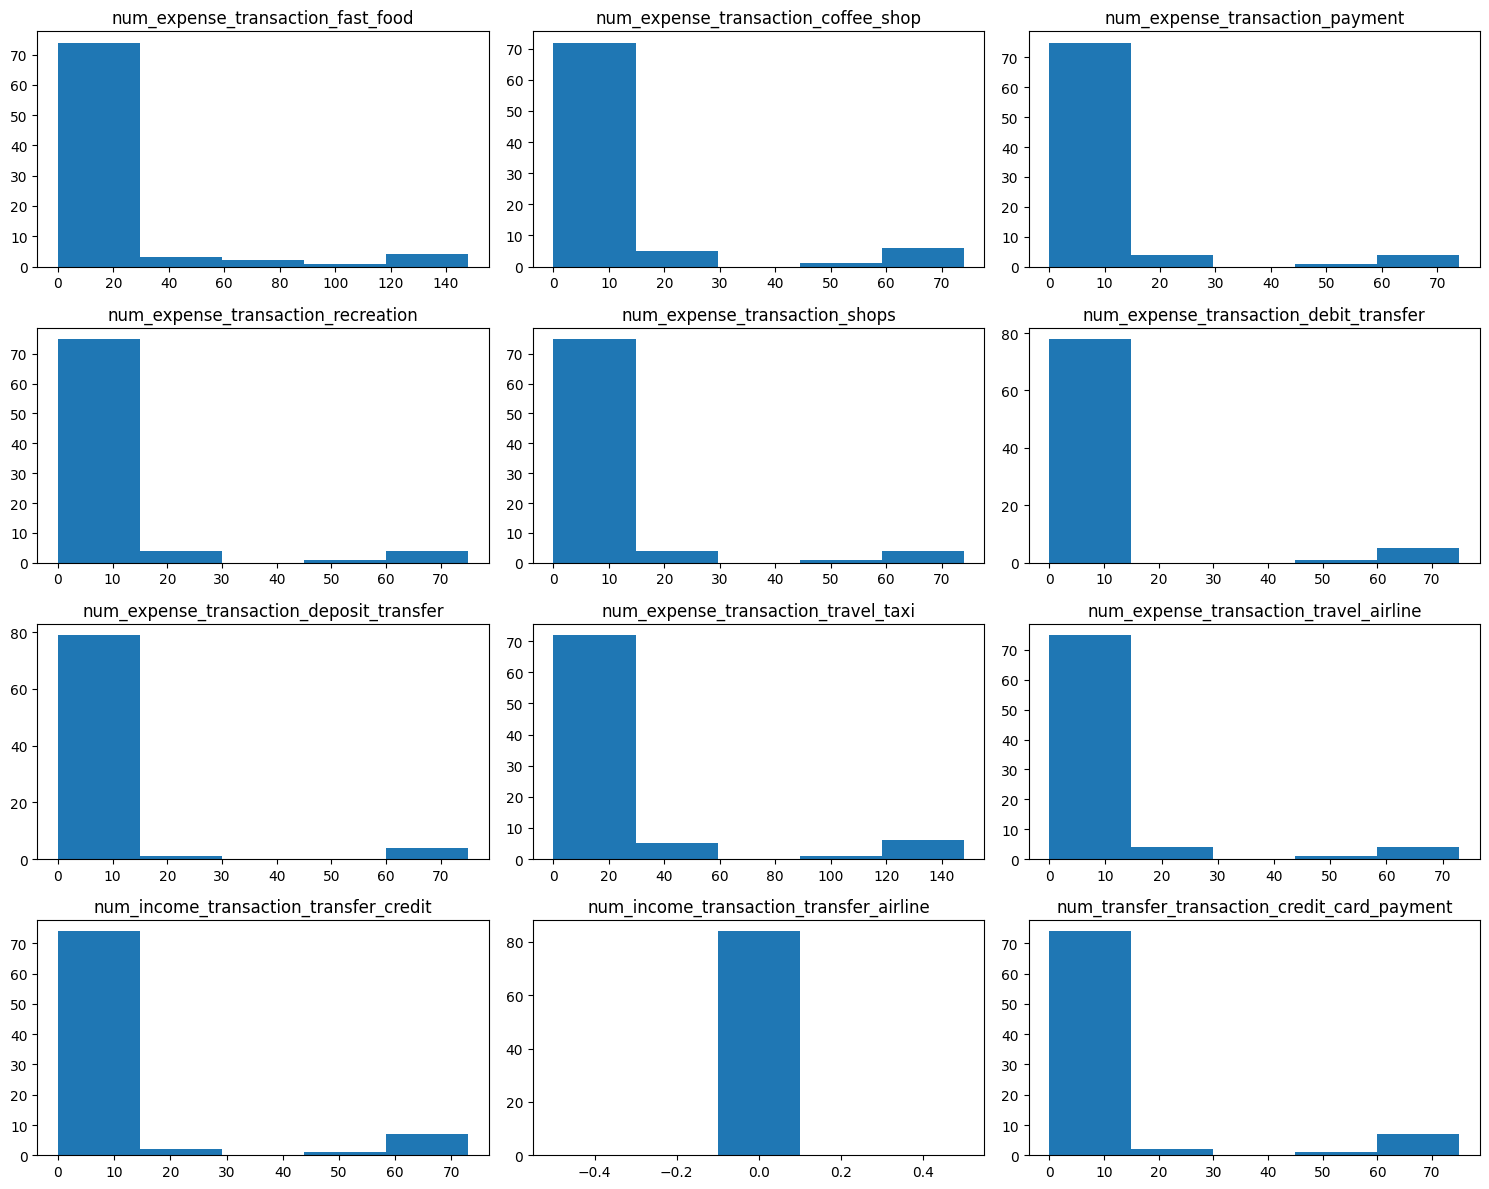

In [37]:
fig, axes = plt.subplots(4,3,figsize = (15,12))
axes = axes.flatten()

for ax, col in zip(axes, users_db.columns[1:]):
  ax.hist(users_db[col], bins = 5)
  ax.set_title(col)

plt.tight_layout()
plt.show()

In [38]:
from numpy import mean
# Mean amount for expense transactions towards food and drinks in fast food chains
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Food and Drink') & (transactions['extra_fields.category.2'] == 'Fast Food')].
                    groupby('user_id')['amount'].
                    mean().
                    rename('amt_expense_transaction_fast_food'),
                    left_on = 'user_id',
                    right_index = True,
                    how = 'left').fillna({'amt_expense_transaction_fast_food': 0})

# Mean amount for expense transactions towards food and drinks in coffee shops
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Food and Drink') & (transactions['extra_fields.category.2'] == 'Coffee Shop')].
                          groupby('user_id')['amount'].
                          mean().
                          rename('amt_expense_transaction_coffee_shop'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'amt_expense_transaction_coffee_shop':0})

# Mean amount of expense transactions towards payment
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Payment')].
                          groupby('user_id')['amount'].
                          mean().
                          rename('amt_expense_transaction_payment'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'amt_expense_transaction_payment':0})

# Mean amount of expense transactions towards recreation (gym and fitness)
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Recreation')].
                          groupby('user_id')['amount'].
                          mean().
                          rename('amt_expense_transaction_recreation'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'amt_expense_transaction_recreation':0})

# Mean amount of expense transactions towards shops (sporting goods)
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Shops')].
                          groupby('user_id')['amount'].
                          mean().
                          rename('amt_expense_transaction_shops'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'amt_expense_transaction_shops':0})

# Mean amount of expense transactions towards transfer (debit)
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Transfer') & (transactions['extra_fields.category.1'] == 'Debit')].
                          groupby('user_id')['amount'].
                          mean().
                          rename('amt_expense_transaction_debit_transfer'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'amt_expense_transaction_debit_transfer':0})

# Mean amount of expense transactions towards transfer (deposit)
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Transfer') & (transactions['extra_fields.category.1'] == 'Deposit')].
                          groupby('user_id')['amount'].
                          mean().
                          rename('amt_expense_transaction_deposit_transfer'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'amt_expense_transaction_deposit_transfer':0})

# Mean amount of expense transactions towards travel (taxi)
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Travel') & (transactions['extra_fields.category.1'] == 'Taxi')].
                          groupby('user_id')['amount'].
                          mean().
                          rename('amt_expense_transaction_travel_taxi'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'amt_expense_transaction_travel_taxi':0})

# Mean amount of expense transactions towards travel (airline and aviation services)
users_db = users_db.merge(transactions[(transactions['type'] == 'expense') & (transactions['extra_fields.category.0'] == 'Travel') & (transactions['extra_fields.category.1'] == 'Airlines and Aviation Services')].
                          groupby('user_id')['amount'].
                          mean().
                          rename('amt_expense_transaction_travel_airline'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'amt_expense_transaction_travel_airline':0})

# Mean amount of income transactions for credit transfer
users_db = users_db.merge(transactions[(transactions['type'] == 'income') & (transactions['extra_fields.category.0'] == 'Transfer') & (transactions['extra_fields.category.1'] == 'Credit')].
                          groupby('user_id')['amount'].
                          mean().
                          rename('amt_income_transaction_transfer_credit'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'amt_income_transaction_transfer_credit':0})

# Mean amount of income transactions for travel transfer (airline and aviation services)
users_db = users_db.merge(transactions[(transactions['type'] == 'income') & (transactions['extra_fields.category.0'] == 'Transfer') & (transactions['extra_fields.category.1'] == 'Travel')].
                          groupby('user_id')['amount'].
                          mean().
                          rename('amt_income_transaction_transfer_airline'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'amt_income_transaction_transfer_airline':0})

# Mean amount of transfer transactions for credit card payment
users_db = users_db.merge(transactions[(transactions['type'] == 'transfer')].
                          groupby('user_id')['amount'].
                          mean().
                          rename('amt_transfer_transaction_credit_card_payment'),
                          left_on = 'user_id',
                          right_index = True,
                          how = 'left').fillna({'amt_transfer_transaction_credit_card_payment':0})


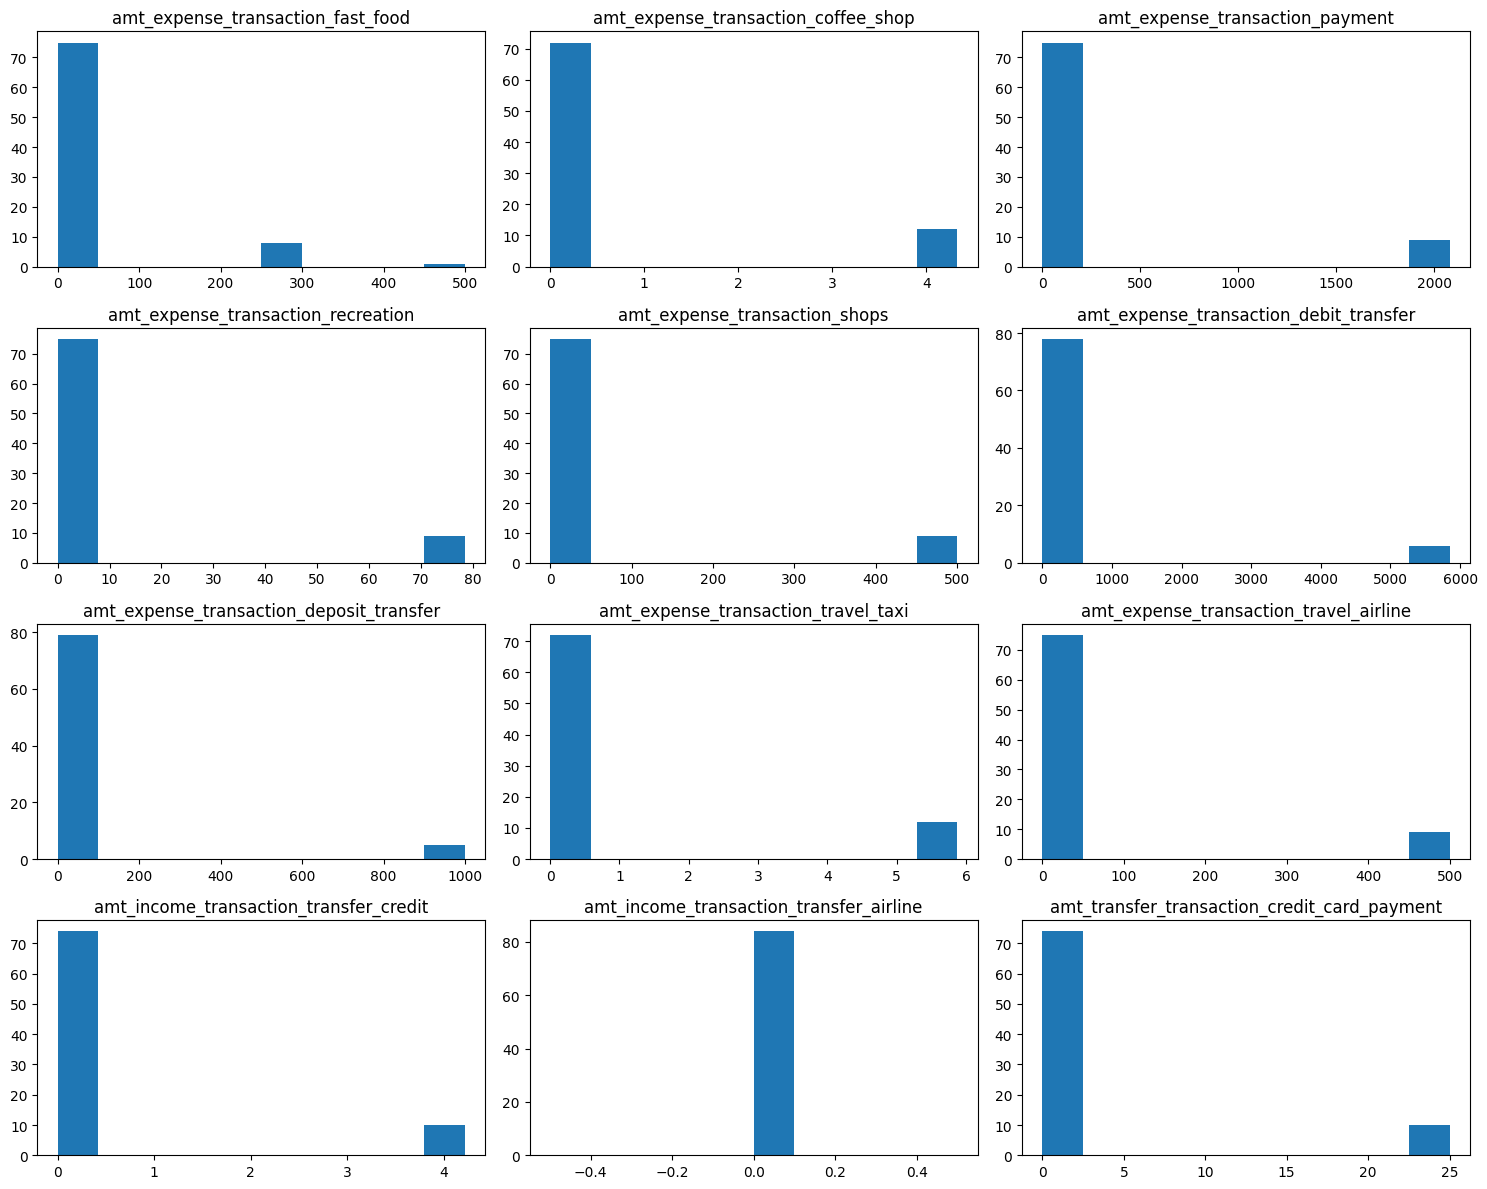

In [39]:
fig, axes = plt.subplots(4, 3, figsize = (15, 12))
axes = axes.flatten()

for ax, col in zip(axes, users_db.columns[13:]):
  ax.hist(users_db[col], bins = 10)
  ax.set_title(col)

plt.tight_layout()
plt.show()

### **Part 2: Unsupervised Learning (Clustering)**
**3. Apply three clustering algorithms of your choice to segment the users. Use suitable metrics and visualisations to determine the best clustering algorithm.**

- Choice of clustering algorithms: K-Means clustering, hierarchial clustering and DBSCAN.
- Choice of metrics: Silhouette score, Davies-Bouldin Index, Calinski-Harabasz Index.

The best clustering algorithm would have a silhouette score close to 1, a low Davies-Bouldin Index and a high Calinski-Harabasz Index.

In [40]:
# Standard scaling
scaler = StandardScaler()
profile_scaled = scaler.fit_transform(users_db.iloc[:, 1:])

1. K-Means Clustering

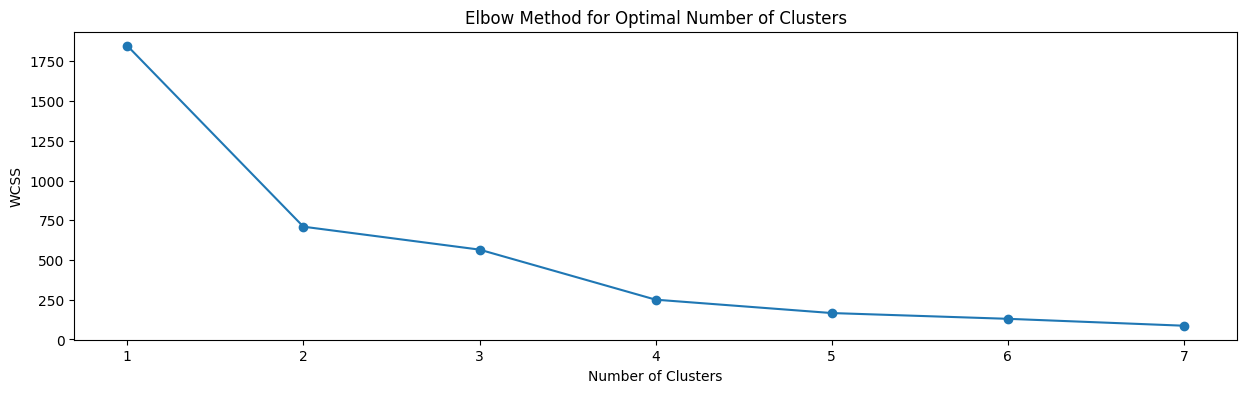

In [45]:
# Find optimal k-means cluster
wcss = []
for k in range(1,8):
  kmeans = KMeans(n_clusters = k, random_state = 42)
  kmeans.fit(profile_scaled)
  wcss.append(kmeans.inertia_)

plt.figure(figsize=(15, 4))
plt.plot(range(1, 8), wcss, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

The elbow plot shows a sharp decrease in inertia as number of clusters increase from 1 to 2, beyong which rate of decrease in inertia slows down. The optimal number of clusters is deemed as 2.

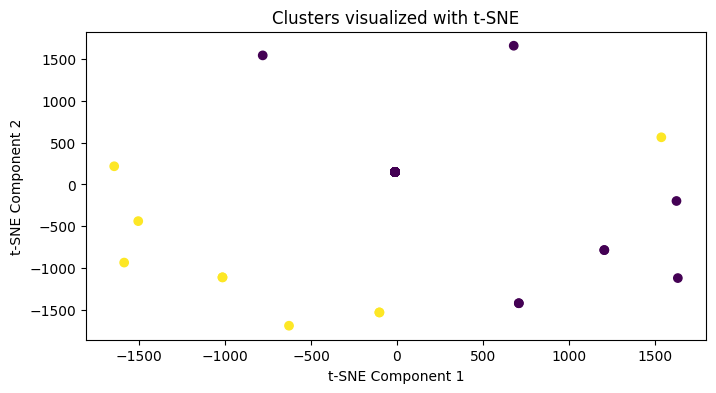

In [42]:
kmeans = KMeans(n_clusters = 2, random_state = 42)
clusters = kmeans.fit_predict(profile_scaled)

# Dimension reduction and visualise using TSNE
tsne = TSNE(n_components = 2, random_state = 42)
X_tsne = tsne.fit_transform(profile_scaled)

plt.figure(figsize=(8, 4))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c = clusters)
plt.title("Clusters visualized with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

We see two well-separated clusters, with the exception of one yellow data point near the purple cluster.

In [49]:
print(f"Silhouette score for K-Means clustering: {round(silhouette_score(profile_scaled, clusters),2)}")
print(f"Davies Bouldin Index for K-Means clustering: {round(davies_bouldin_score(profile_scaled, clusters), 2)}")
print(f"Calinski-Harabasz Index for K-Means Clustering: {round(calinski_harabasz_score(profile_scaled, clusters),2)}")

Silhouette score for K-Means clustering: 0.84
Davies Bouldin Index for K-Means clustering: 0.63
Calinski-Harabasz Index for K-Means Clustering: 131.53


2. Hierarchial Clustering

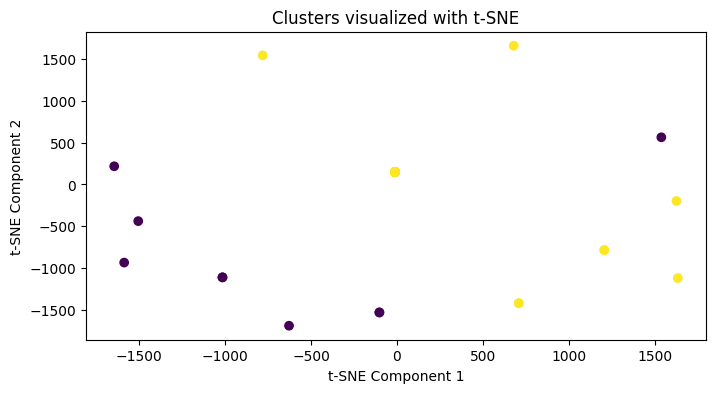

In [52]:
agglo_cluster = AgglomerativeClustering(n_clusters = 2, linkage = 'ward')
agglo_cluster.fit_predict(profile_scaled)

# Dimension reduction and visualise using TSNE
tsne = TSNE(n_components = 2, random_state = 42)
X_tsne = tsne.fit_transform(profile_scaled)

plt.figure(figsize=(8, 4))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c = agglo_cluster.labels_)
plt.title("Clusters visualized with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

We see two well-separated clusters, with the exception of one yellow data point near the purple cluster.

In [54]:
print(f"Silhouette score for Agglomerative clustering: {round(silhouette_score(profile_scaled, agglo_cluster.labels_),2)}")
print(f"Davies Bouldin Index for Agglomerative clustering: {round(davies_bouldin_score(profile_scaled, agglo_cluster.labels_), 2)}")
print(f"Calinski-Harabasz Index for Agglomerative Clustering: {round(calinski_harabasz_score(profile_scaled, agglo_cluster.labels_),2)}")

Silhouette score for Agglomerative clustering: 0.84
Davies Bouldin Index for Agglomerative clustering: 0.63
Calinski-Harabasz Index for Agglomerative Clustering: 131.53


3. DBSCAN

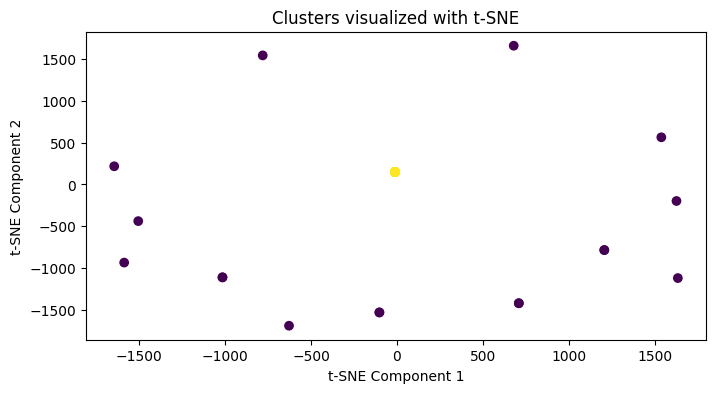

In [59]:
density_cluster = DBSCAN(eps = 0.7, min_samples = 5)
density_cluster.fit_predict(profile_scaled)

# Dimension reduction and visualise using TSNE
tsne = TSNE(n_components = 2, random_state = 42)
X_tsne = tsne.fit_transform(profile_scaled)

plt.figure(figsize=(8, 4))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c = density_cluster.labels_)
plt.title("Clusters visualized with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

Every data point is clustered into one cluster and there is one outlier.

In [60]:
print(f"Silhouette score for DBSCAN: {round(silhouette_score(profile_scaled, density_cluster.labels_),2)}")
print(f"Davies Bouldin Index for DBSCAN: {round(davies_bouldin_score(profile_scaled, density_cluster.labels_), 2)}")
print(f"Calinski-Harabasz Index for DBSCAN: {round(calinski_harabasz_score(profile_scaled, density_cluster.labels_),2)}")

Silhouette score for DBSCAN: 0.78
Davies Bouldin Index for DBSCAN: 0.97
Calinski-Harabasz Index for DBSCAN: 66.2


Clustering algorithm of choice: K-Means Clustering.

**4. Interpret the characteristics of each cluster.**

- Of the 84 users with at least one transaction, 75 are in one cluster and 9 are in another.
- Users in cluster 1 had low number of expense transactions for payment, for shops and for travelling using airline and aviation services (less than 20).
- Users in cluster 1 had low average amount for expense transaction in fast food chains, for recreation and for travelling using airline and aviation services.

In [61]:
users_db['Cluster'] = clusters
users_db.groupby('Cluster').size()

,0
Cluster,
0,75
1,9


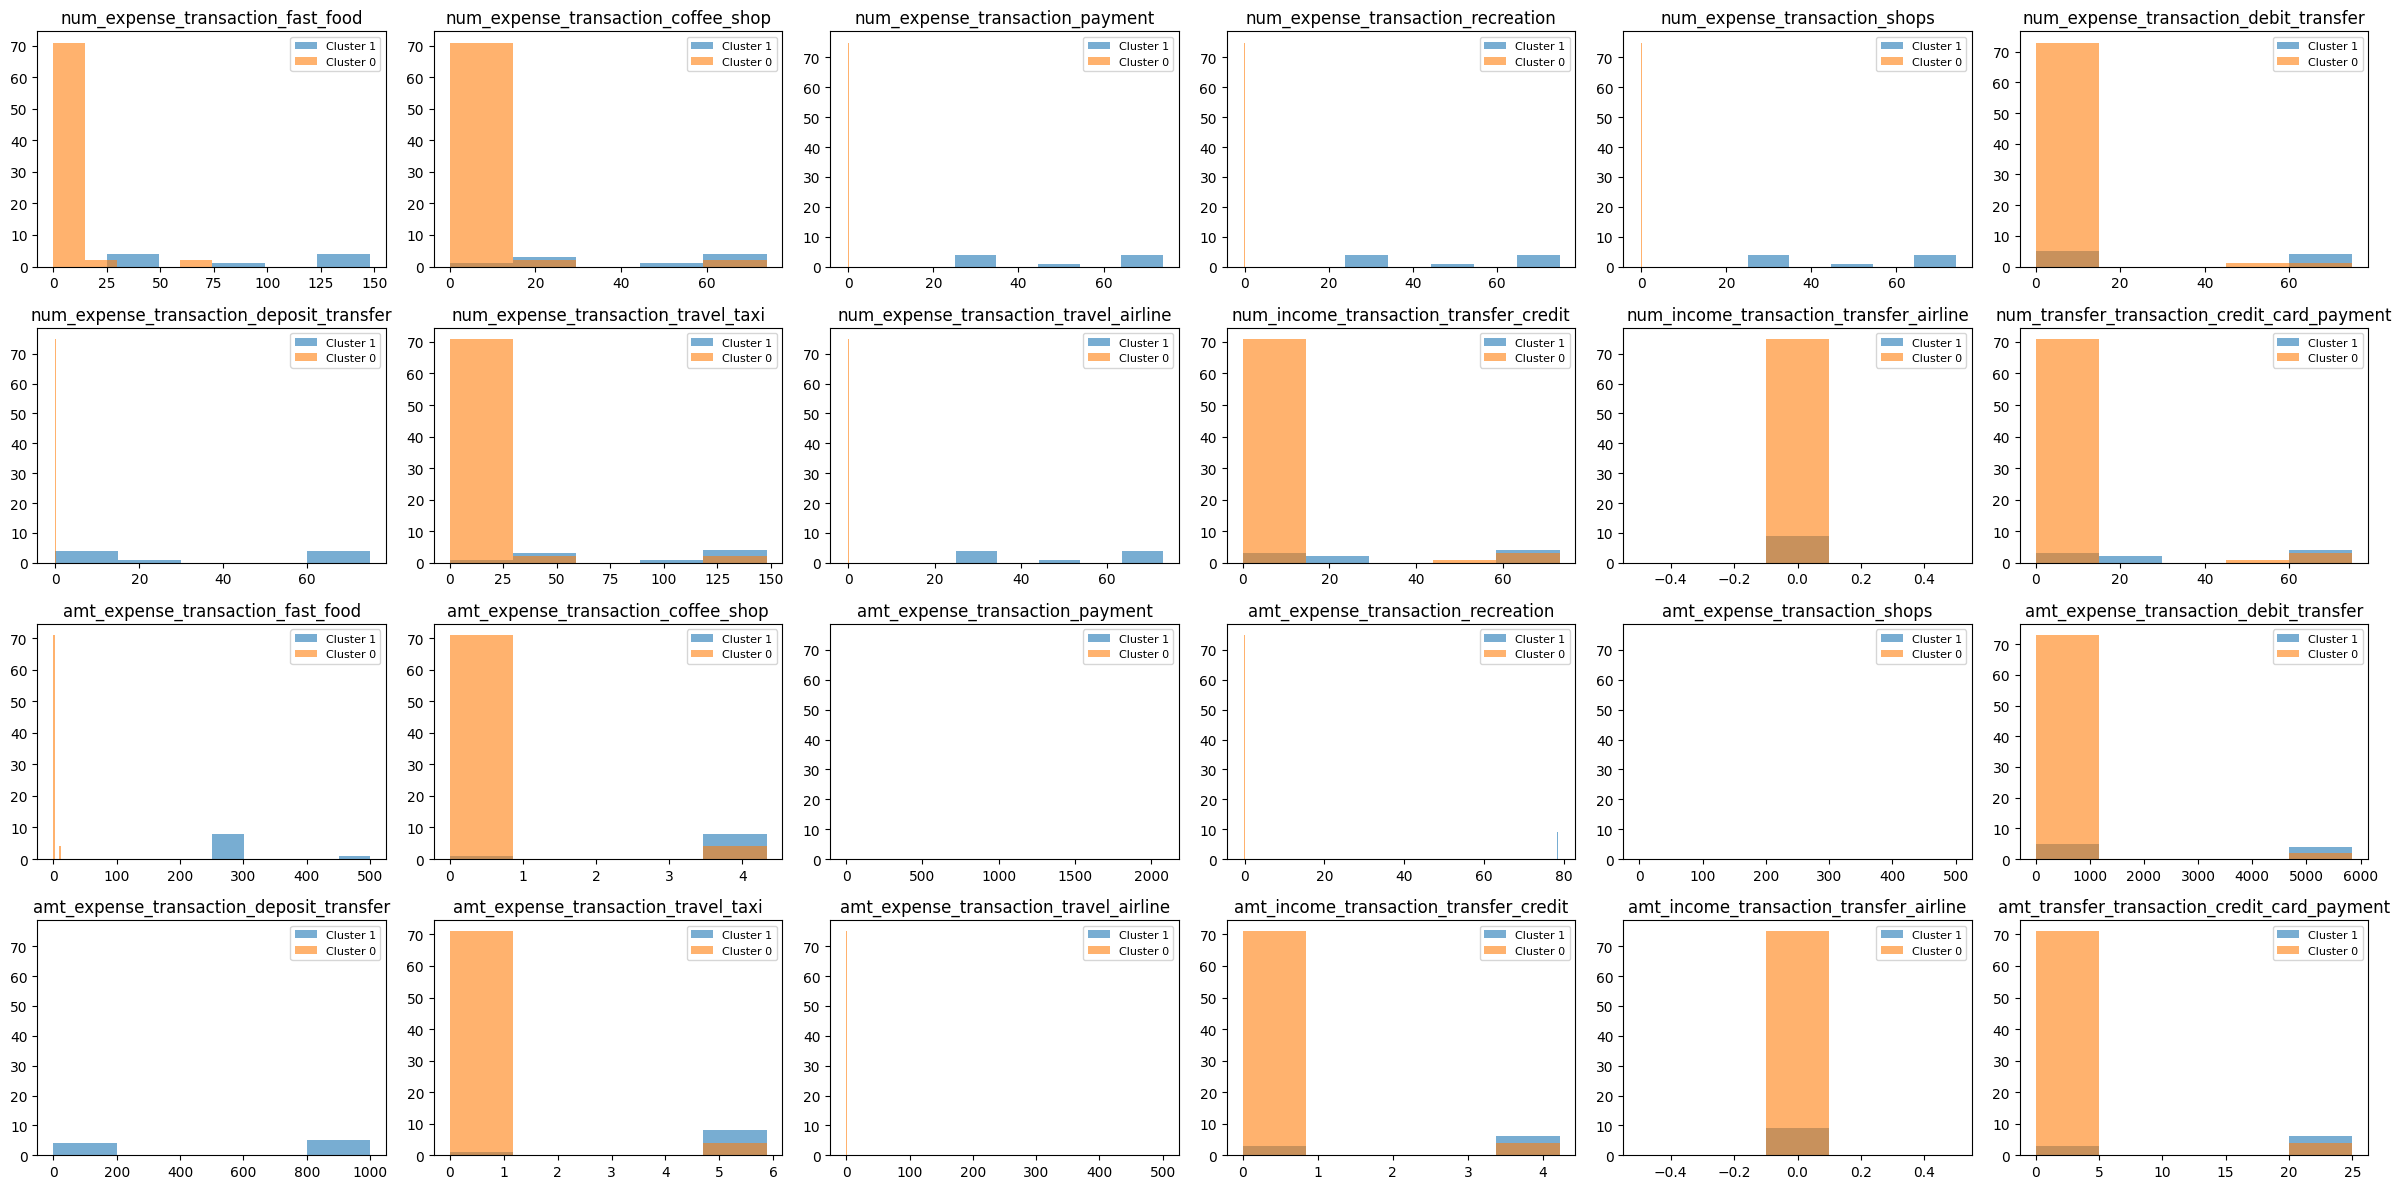

In [64]:
fig, axes = plt.subplots(4, 6, figsize = (24, 12))
axes = axes.flatten()

clusters = users_db['Cluster'].unique()

for ax, col in zip(axes, users_db.columns[1:]):
    for cluster in clusters:
        data = users_db.loc[users_db['Cluster'] == cluster, col]
        ax.hist(
            data,
            bins=5,
            alpha=0.6,
            label=f'Cluster {cluster}'
        )

    ax.set_title(col)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()